# **WA-R-SA Data Aggregator**
### *Whitefield Robotics Scouting Analytics Datapad Aggregator and Point Tabulator*
### Created by Jackson Holbrook
#### *Freight Frenzy Season*


The function of this notebook is to aggregate all datapad data sets into one table, then multiply the frequency of each stat (how many times team x scored a particle) by the associated points (each particle is worth 2 pts).

To begin, get the data tables from the Datapads and drop them in the same directory (folder) as this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab

The refMatrix is laid out as `"statName" : ["statName", pointValue, "A/T/E", "B/I/M", ["multStats"]]`
statName is the name of the statistic being tracked, ie, `"rePosBase"`

pointValue is how many points one of that stat is worth, ie, "placeSt" is 1 point each

A/T/E is wether the stat happens in autonomous, teleOp, or endGame (AUTO, TELE, and END, respectively)

B/I/M denotes wether the stat is a BOOLean, INTeger, or MULTiplier

**Only for multipliers:** `["multStats"]` is an array of strings. This is where the stats for what stats get the multiplier, if it is active.

These stat names ***Must*** be the same as the ones in the tables being imported- the names at the beginning of the Datapad code. (a stat = a statistic that is being tracked, ex. "number of particles in depot". The stat name variables should be something like `parkWarehouse` or something short like that).

In [2]:
#rfMtxOrder = ["STAT1", "STAT2", "STAT3", "STAT4"]
rfMtxOrder = ["autoDuck", "parkSquare", "parkWarehouse", "complParked", "correctLevel",
              "usedTSE", "autoSq", "autoShipHub", "shipSq", "shipLvl1", "shipLvl2",
              "shipLvl3", "shipShared", "duckCt", "hubBalanced", "sharedTipped", "endPark",
              "compEndPark", "hubCapped"]

refMatrix = {
    "autoDuck": ["autoDuck", 10, "AUTO", "BOOL"],
    "parkSquare" : ["parkSquare", 3, "AUTO", "BOOL"],
    "parkWarehouse": ["parkWarehouse", 5, "AUTO", "BOOL"],
    "complParked" : ["complParked" , 2, "AUTO", "MULT", ["parkSquare", "parkWarehouse"]],
    "correctLevel": ["correctLevel", 10, "AUTO", "BOOL"],
    "usedTSE": ["usedTSE", 2, "AUTO", "MULT", ["correctLevel"]],
    "autoSq": ["autoSq", 2, "AUTO", "INT"],
    "autoShipHub": ["autoShipHub", 6, "AUTO", "INT"],
    
    "shipSq" : ["shipSq", 1, "TELE", "INT"],
    "shipLvl1" : ["shipLvl1", 2, "TELE", "INT"],
    "shipLvl2" : ["shipLvl2", 4, "TELE", "INT"],
    "shipLvl3" : ["shipLvl3", 6, "TELE", "INT"],
    "shipShared" : ["shipLvl3", 4, "TELE", "INT"],
        
    "duckCt" : ["duckCt", 6, "END", "INT"],
    "hubBalanced" : ["hubBalanced", 10, "END", "BOOL"],
    "sharedTipped" : ["sharedTipped", 20, "END", "BOOL"],
    "endPark" : ["endPark", 3, "END", "BOOL"],
    "compEndPark" : ["compEndPark", 2, "END", "MULT", ["endPark"]],
    "hubCapped" : ["hubCapped", 15, "END", "BOOL"],
}
numStats = len(refMatrix)

Increment this value by 1 for every competition.

In [3]:
competition = 1 #League Championship

###### Importing the data tables

In [4]:
data1 = pd.read_csv('data1.txt')
data1.head()

,TEAM_NUM,MATCH,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,autoShipHub,...,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped
0,4327,0,0,0,1,1,0,1,0,0,...,0,0,4,0,0,0,0,0,0,0
1,12469,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,12769,0,0,0,1,0,1,0,0,0,...,0,0,0,3,0,0,1,0,0,0
3,19987,1,0,1,0,0,0,1,0,0,...,0,0,0,4,7,0,0,0,1,0
4,12769,2,0,0,1,1,1,1,0,1,...,0,0,0,1,0,0,1,0,0,1


In [5]:
data2 = pd.read_csv('data2.txt')
# data2.head()

In [6]:
data3 = pd.read_csv('data3.txt')
# data3.head()

In [7]:
data4 = pd.read_csv('data4.txt')
# data4.head()

In [8]:
# masterdata = 
try:
#     global masterdata
    masterdata = pd.read_csv('masterdata.csv')
    masterdata.drop(masterdata.columns[0],axis=1,inplace=True)
except:
#     global masterdata
    masterdata = pd.DataFrame(columns=['TEAM_NUM', 'MATCH', 'TOTAL', 'STAT', 'VALUES', 'A/T/E', 'COMPETITION'])
    
masterdata.head()

,TEAM_NUM,MATCH,TOTAL,STAT,VALUES,A/T/E,COMPETITION,MATCHCT
0,1002,0,92,autoDuck,0,AUTO,1,0.0
1,1002,0,92,parkSquare,0,AUTO,1,0.0
2,1002,0,92,parkWarehouse,10,AUTO,1,0.0
3,1002,0,92,complParked,1,AUTO,1,0.0
4,1002,0,92,correctLevel,20,AUTO,1,0.0


This drops that "Unnamed:0" coulmn that annoyingly exists from the file's creation. (It's the df index, but there was another index added when imported here, so its gotta go)

masterdata.drop(masterdata.columns[0],axis=1,inplace=True)
masterdata.head()

###### Merging dataframes

Creates `mtxStr` as a list of the columns to merge on. Has to be a string so that the `exec` command works properly. `exec` is kind of a hack- it executes a string as if it was just a line typed into an editor. For instance, `exec("print("Hello There")")` would have the same output as `print("Hello There")`, but as shown below, Python's string formatting can be used to change what gets executed.

In [9]:
mtxStr = "'TEAM_NUM', 'MATCH', "
for i in range(len(rfMtxOrder)):
    mtxStr += "rfMtxOrder[{}], ".format(i)
print(mtxStr)

'TEAM_NUM', 'MATCH', rfMtxOrder[0], rfMtxOrder[1], rfMtxOrder[2], rfMtxOrder[3], rfMtxOrder[4], rfMtxOrder[5], rfMtxOrder[6], rfMtxOrder[7], rfMtxOrder[8], rfMtxOrder[9], rfMtxOrder[10], rfMtxOrder[11], rfMtxOrder[12], rfMtxOrder[13], rfMtxOrder[14], rfMtxOrder[15], rfMtxOrder[16], rfMtxOrder[17], rfMtxOrder[18], 


In [10]:
exec("data12 = pd.merge(data1, data2, how='outer', on=[%s])" % (mtxStr))
exec("data34 = pd.merge(data3, data4, how='outer', on=[%s])" % (mtxStr))
exec("alldata = pd.merge(data12, data34, how='outer', on=[%s])" % (mtxStr))

###### Tabulating Data
*(multiplying each stat by its point value)*

In [11]:
alldata = alldata.sort_values(['TEAM_NUM', 'MATCH'])
alldata.head(200)

,TEAM_NUM,MATCH,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,autoShipHub,...,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped
16,1002,0,0,0,1,1,1,1,0,1,...,0,0,3,0,6,0,0,0,0,0
0,4327,0,0,0,1,1,0,1,0,0,...,0,0,4,0,0,0,0,0,0,0
14,7482,0,0,0,1,0,0,0,0,0,...,0,0,0,0,5,0,0,0,0,0
19,8875,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
9,9686,2,0,0,1,1,0,1,0,1,...,0,0,2,0,0,0,0,1,1,0
7,11127,0,1,1,0,1,1,0,0,1,...,0,0,0,4,8,0,1,0,0,0
24,11347,6,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1,12469,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23,12762,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,12762,7,0,0,1,1,1,1,0,1,...,0,0,3,0,7,0,0,0,1,0


In [12]:
#for i in range(len(rfMtxOrder)):
    #alldata[rfMtxOrder[i]] = alldata[rfMtxOrder[i]].multiply(refMatrix[rfMtxOrder[i]][1])
    #alldata[refMatrix[rfMtxOrder[i]][0]] = alldata[refMatrix[rfMtxOrder[i]][0]].multiply(refMatrix[rfMtxOrder[i]][1])

for stat in rfMtxOrder:
    if refMatrix[stat][3] == "MULT": #if the stat is a multiplier
#         print(stat, " is mult")
        for multStat in refMatrix[stat][4]: #for every stat in the arr of stats that get the multiplier
            alldata[multStat] = alldata[multStat].multiply(refMatrix[stat][1]) #multiply the stat by the multiplier
    else:
        alldata[stat] = alldata[stat].multiply(refMatrix[stat][1]) #multiply the stat by its point value
    
alldata.head(50)

,TEAM_NUM,MATCH,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,autoShipHub,...,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped
16,1002,0,0,0,10,1,20,1,0,6,...,0,0,18,0,36,0,0,0,0,0
0,4327,0,0,0,10,1,0,1,0,0,...,0,0,24,0,0,0,0,0,0,0
14,7482,0,0,0,10,0,0,0,0,0,...,0,0,0,0,30,0,0,0,0,0
19,8875,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0
9,9686,2,0,0,10,1,0,1,0,6,...,0,0,12,0,0,0,0,6,1,0
7,11127,0,10,6,0,1,20,0,0,6,...,0,0,0,16,48,0,20,0,0,0
24,11347,6,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,6,1,0
1,12469,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23,12762,5,0,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,12762,7,0,0,10,1,20,1,0,6,...,0,0,18,0,42,0,0,0,1,0


###### Team-consecutive match count
(teams get their own match counts, not based on when their match was)

In [13]:
teamlist = []
alldata.insert(2, "MATCHCT", -1)
matchcount = 0
#exec('testDF = pd.DataFrame(columns = [%s])' % (mtxStr))

for i in range(len(alldata)):
    if alldata.at[i, 'TEAM_NUM'] == alldata.at[0, 'TEAM_NUM']:
        matchcount += 1
print("matchcount: ", matchcount)
for m in range(matchcount):
    for i in range(len(alldata)):
        #if alldata.at[i, 'TEAM_NUM'] == 11127:
            #testDF.append(alldata[i, 'TEAM_NUM'])
        if alldata.at[i, 'TEAM_NUM'] not in teamlist:
            if alldata.at[i, 'MATCHCT'] == -1:
                teamlist.append(alldata.at[i, 'TEAM_NUM'])
                alldata.at[i, 'MATCHCT'] = m
    teamlist.clear()
alldata.tail(10)

matchcount:  1


,TEAM_NUM,MATCH,MATCHCT,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,...,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped
22,13245,4,-1,0,0,0,0,0,1,0,...,0,0,18,0,36,0,0,0,0,15
6,13451,1,0,0,0,10,1,0,1,0,...,0,0,0,16,12,10,0,0,0,0
5,15173,0,0,0,0,10,1,20,0,0,...,0,0,0,0,48,0,0,0,0,0
10,17075,0,-1,10,6,0,1,0,0,0,...,0,0,24,0,54,0,0,6,0,0
8,17075,1,0,10,6,0,1,0,0,0,...,0,0,24,0,18,0,0,0,0,0
21,18304,2,0,0,6,0,1,0,1,0,...,0,0,0,20,0,0,0,6,0,0
15,19571,0,0,0,6,0,1,20,1,0,...,0,0,6,12,48,0,20,0,0,0
17,19571,0,-1,10,6,0,1,20,1,0,...,0,0,30,4,0,0,0,6,1,0
3,19987,1,0,0,6,0,0,0,1,0,...,0,0,0,16,42,0,0,0,1,0
18,20127,0,0,0,0,0,0,0,1,0,...,0,0,0,0,36,0,0,0,0,0


In [14]:
alldata.head(100)

,TEAM_NUM,MATCH,MATCHCT,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,...,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped
16,1002,0,0,0,0,10,1,20,1,0,...,0,0,18,0,36,0,0,0,0,0
0,4327,0,0,0,0,10,1,0,1,0,...,0,0,24,0,0,0,0,0,0,0
14,7482,0,0,0,0,10,0,0,0,0,...,0,0,0,0,30,0,0,0,0,0
19,8875,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0
9,9686,2,0,0,0,10,1,0,1,0,...,0,0,12,0,0,0,0,6,1,0
7,11127,0,0,10,6,0,1,20,0,0,...,0,0,0,16,48,0,20,0,0,0
24,11347,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,6,1,0
1,12469,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
23,12762,5,0,0,0,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0
25,12762,7,-1,0,0,10,1,20,1,0,...,0,0,18,0,42,0,0,0,1,0


###### Flattening (Melting) (un-pivoting) data

In [15]:
alldata['TOTAL'] = alldata.sum(axis=1)-alldata.TEAM_NUM-alldata.MATCH-alldata.MATCHCT

In [16]:
alldata.head()

,TEAM_NUM,MATCH,MATCHCT,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,...,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped,TOTAL
16,1002,0,0,0,0,10,1,20,1,0,...,0,18,0,36,0,0,0,0,0,92
0,4327,0,0,0,0,10,1,0,1,0,...,0,24,0,0,0,0,0,0,0,36
14,7482,0,0,0,0,10,0,0,0,0,...,0,0,0,30,0,0,0,0,0,40
19,8875,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,8
9,9686,2,0,0,0,10,1,0,1,0,...,0,12,0,0,0,0,6,1,0,37


In [17]:
savedColumns = ["TEAM_NUM", "MATCH", "MATCHCT", "TOTAL"]
melteddata = pd.melt(alldata,
                    id_vars=savedColumns[0:],
                    value_vars=list(alldata.columns[3:len(rfMtxOrder)+3]), #that number 3 is len(savedColums) - 1   
                    var_name='STAT',
                    value_name='VALUES')
melteddata = melteddata.sort_values(["TEAM_NUM", "MATCH"])
melteddata.head(20)
#export_csv_melt = melteddata.to_csv("melteddata.csv")

,TEAM_NUM,MATCH,MATCHCT,TOTAL,STAT,VALUES
0,1002,0,0,92,autoDuck,0
26,1002,0,0,92,parkSquare,0
52,1002,0,0,92,parkWarehouse,10
78,1002,0,0,92,complParked,1
104,1002,0,0,92,correctLevel,20
130,1002,0,0,92,usedTSE,1
156,1002,0,0,92,autoSq,0
182,1002,0,0,92,autoShipHub,6
208,1002,0,0,92,shipSq,0
234,1002,0,0,92,shipLvl1,0


In [18]:
# adds auto / tele identifier
melteddata['A/T/E'] = "0"
for index, row in melteddata.iterrows():
    melteddata.loc[index,'A/T/E'] = refMatrix[melteddata.loc[index,'STAT']][2]
melteddata.head()

,TEAM_NUM,MATCH,MATCHCT,TOTAL,STAT,VALUES,A/T/E
0,1002,0,0,92,autoDuck,0,AUTO
26,1002,0,0,92,parkSquare,0,AUTO
52,1002,0,0,92,parkWarehouse,10,AUTO
78,1002,0,0,92,complParked,1,AUTO
104,1002,0,0,92,correctLevel,20,AUTO


In [19]:
melteddata['COMPETITION'] = competition

In [20]:
melteddata.head(100)

,TEAM_NUM,MATCH,MATCHCT,TOTAL,STAT,VALUES,A/T/E,COMPETITION
0,1002,0,0,92,autoDuck,0,AUTO,1
26,1002,0,0,92,parkSquare,0,AUTO,1
52,1002,0,0,92,parkWarehouse,10,AUTO,1
78,1002,0,0,92,complParked,1,AUTO,1
104,1002,0,0,92,correctLevel,20,AUTO,1
...,...,...,...,...,...,...,...,...
5,11127,0,0,127,autoDuck,10,AUTO,1
31,11127,0,0,127,parkSquare,6,AUTO,1
57,11127,0,0,127,parkWarehouse,0,AUTO,1
83,11127,0,0,127,complParked,1,AUTO,1


###### Appending to the masterdata file

In [21]:
masterdata = masterdata.append(melteddata, sort=False)

In [22]:
masterdata.head(20)

,TEAM_NUM,MATCH,TOTAL,STAT,VALUES,A/T/E,COMPETITION,MATCHCT
0,1002,0,92,autoDuck,0,AUTO,1,0.0
1,1002,0,92,parkSquare,0,AUTO,1,0.0
2,1002,0,92,parkWarehouse,10,AUTO,1,0.0
3,1002,0,92,complParked,1,AUTO,1,0.0
4,1002,0,92,correctLevel,20,AUTO,1,0.0
5,1002,0,92,usedTSE,1,AUTO,1,0.0
6,1002,0,92,autoSq,0,AUTO,1,0.0
7,1002,0,92,autoShipHub,6,AUTO,1,0.0
8,1002,0,92,shipSq,0,TELE,1,0.0
9,1002,0,92,shipLvl1,0,TELE,1,0.0


###### Exporting dataframe
This file will be in the same directory (folder) as this notebook.

In [39]:
export_alldata = alldata.to_csv("alldata.csv")

In [23]:
export_csv = masterdata.to_csv("masterdata.csv")

### Data Visualization

In [24]:
alldata.head(100)

,TEAM_NUM,MATCH,MATCHCT,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,...,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped,TOTAL
16,1002,0,0,0,0,10,1,20,1,0,...,0,18,0,36,0,0,0,0,0,92
0,4327,0,0,0,0,10,1,0,1,0,...,0,24,0,0,0,0,0,0,0,36
14,7482,0,0,0,0,10,0,0,0,0,...,0,0,0,30,0,0,0,0,0,40
19,8875,0,0,0,0,0,0,0,0,0,...,0,0,8,0,0,0,0,0,0,8
9,9686,2,0,0,0,10,1,0,1,0,...,0,12,0,0,0,0,6,1,0,37
7,11127,0,0,10,6,0,1,20,0,0,...,0,0,16,48,0,20,0,0,0,127
24,11347,6,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,6,1,0,8
1,12469,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
23,12762,5,0,0,0,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,20
25,12762,7,-1,0,0,10,1,20,1,0,...,0,18,0,42,0,0,0,1,0,99


In [25]:
exec("totalstatdata = pd.DataFrame(columns=[%s])" % (mtxStr))
totalstatdata.drop(totalstatdata.columns[1],axis=1,inplace=True)
totalstatdata.head()

,TEAM_NUM,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,autoShipHub,shipSq,shipLvl1,shipLvl2,shipLvl3,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped


In [26]:
for i, row in alldata.iterrows():
    team = row[0]
    if team in list(totalstatdata['TEAM_NUM']):
        targetRow = totalstatdata.loc[totalstatdata['TEAM_NUM'] == team]
        for col in targetRow:
            if col not in ['TEAM_NUM']:
                totalstatdata.at[targetRow.index[0], col] += row[col]
    else:
        totalstatdata = totalstatdata.append(row)

totalstatdata.head(20)

,TEAM_NUM,autoDuck,parkSquare,parkWarehouse,complParked,correctLevel,usedTSE,autoSq,autoShipHub,shipSq,...,shipShared,duckCt,hubBalanced,sharedTipped,endPark,compEndPark,hubCapped,MATCH,MATCHCT,TOTAL
16,1002,0,0,10,1,20,1,0,6,0,...,0,36,0,0,0,0,0,0.0,0.0,92.0
0,4327,0,0,10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,36.0
14,7482,0,0,10,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0.0,0.0,40.0
19,8875,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,0,0,0.0,0.0,8.0
9,9686,0,0,10,1,0,1,0,6,0,...,0,0,0,0,6,1,0,2.0,0.0,37.0
7,11127,10,6,0,1,20,0,0,6,0,...,16,48,0,20,0,0,0,0.0,0.0,127.0
24,11347,0,0,0,0,0,1,0,0,0,...,0,0,0,0,6,1,0,6.0,0.0,8.0
1,12469,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1.0,0.0,1.0
23,12762,0,0,10,1,40,1,0,6,0,...,0,42,0,0,0,1,0,12.0,-1.0,119.0
2,12769,0,0,20,1,40,1,0,6,0,...,16,0,0,40,0,0,15,2.0,-1.0,139.0


In [27]:
teamDict = {
    10000 : "Team One", #these four are for testing
    20000 : "Team Two",
    30000 : "Team Three",
    77777 : "Sevens",
    4327 : "Silver Titans",
    11127 : "Whitefield Robotics",
    12769 : "Rebellion Eng",
    12469 : "Rebellion Eng",
    19571 : "The Robo Brigade",
    1002 : "CircuitRunners - Surge",
    15173 : "Robotic Eagles",
    9686 : "Raiders of the ARC - Blk",
    18304 : "Ultraviolet",
    11026 : "Rebel Robotics",
    13451 : "Oceanus",
    12961 : "Checkmate",
    20172 : "Prometheus",
    20127 : "Prometheus",
    12762 : "Tech Titans",
    12864 : "Raiders of the ARC - Crimson",
    10219 : "Batteries Not Included",
    19987 : "Blue Screen of Death 1.0",
    9785 : "Cronos",
    16600 : "FLS",
    7482 : "Axel-otis",
    8875 : "PythonX",
    13245 : "Arcturus",
    17075 : "WArobotics",
    11347 : "CircuitRunners - Blackout",
    17456 : "Atlantis",
    18009 : "The Drill Bits",
    14165 : "Pebblebrook OG Team",
    16313 : "Pebblebrook Rookies",
    18547 : "W.A.Robotics",
    8678 : "Controlled Chaos",
    19750 : "???"
}

In [28]:

# teamDict = {}
# for i in range(len(alldata)):
#     num = alldata.at[i, 'TEAM_NUM']
#     if num not in teamDict:
#         teamDict[num] = 0
# print(teamDict)

# totalstatdata = pd.DataFrame(alldata)
# totalstatdata.drop(columns=['MATCH', 'MATCHCT'])
# totalstatdata.sort_values(['TEAM_NUM'])
# totalstatdata.reset_index()
# print(totalstatdata)

        

In [29]:
# Constants for plots
exclude = ['MATCH', 'TOTAL']
#Exclude the multiplier stats, they arent useful in this graph
for stat in rfMtxOrder:
    if refMatrix[stat][3] == "MULT":
        exclude.append(stat)

plt.rcParams['figure.figsize'] = [15, 15]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


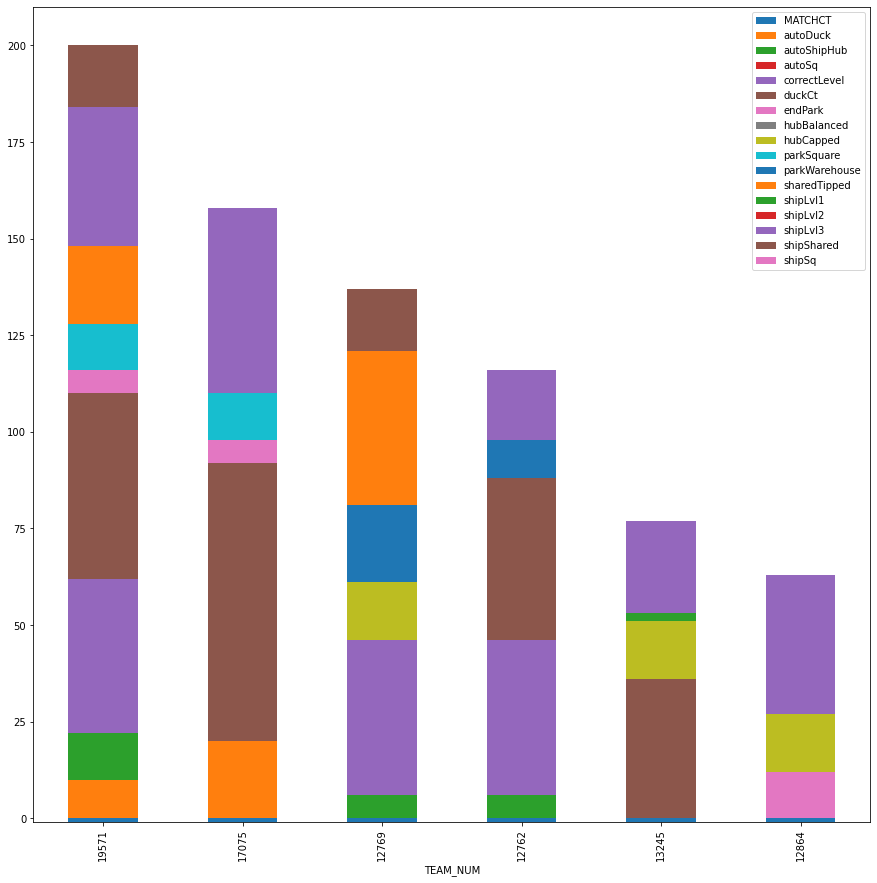

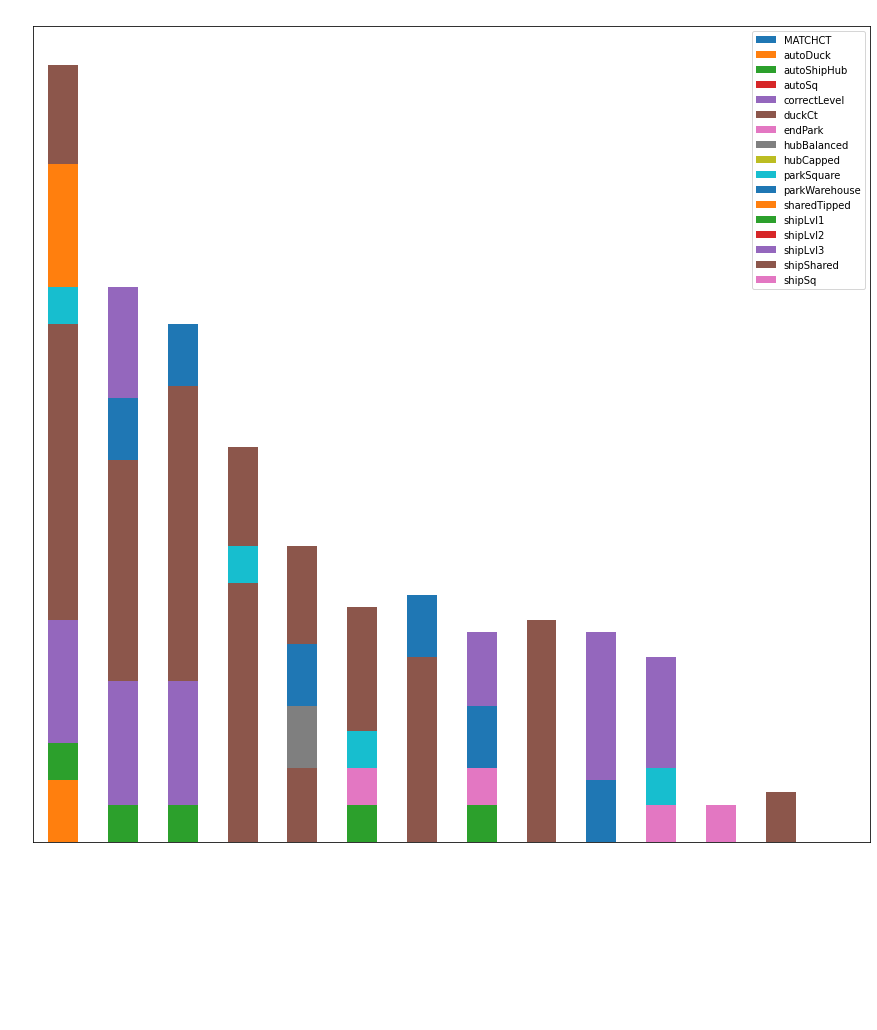

In [30]:
# fig, ax = plt.subplots()

# fig = plt.figure()

#sort it
totalstatdata = totalstatdata.sort_values(['TOTAL'], ascending=False)

#plot it
totalstatdata.loc[:, totalstatdata.columns.difference(exclude)].groupby(
    ['MATCHCT']).plot(x='TEAM_NUM', kind='bar', stacked=True)

#style it
plt.title("Team vs. Total Pts; Stats", color='white', fontsize=17)
plt.xlabel("Team Name", color='white', fontsize=17)
plt.tick_params(colors='white')

# Change tick labels to team name
ax = plt.axes()
labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
for i in range(len(labels)):
    labels[i] = teamDict[int(labels[i])]
# print(labels)
ax.set_xticklabels(labels, fontsize=12)
plt.show()

In [31]:
matchdivdata = pd.DataFrame(columns=['TEAM_NUM', 'AUTO', 'TELE', 'END'])


#Set up df
for i, row in totalstatdata.iterrows():
    team = row[0]
    matchdivdata = matchdivdata.append(
            pd.DataFrame([[team, 0, 0, 0]],
                        columns=['TEAM_NUM', 'AUTO', 'TELE', 'END'],
                        index=[team]))
# matchdivdata.head()

In [32]:
for i, row in totalstatdata.iterrows():
    team = row[0]
    if team in list(matchdivdata['TEAM_NUM']): #if it exists
        dataRow = totalstatdata.loc[totalstatdata['TEAM_NUM'] == team]
#         print(dataRow)
        for col in dataRow:
            if col not in ['TEAM_NUM', 'MATCH', 'MATCHCT', 'TOTAL']:
                if refMatrix[col][3] != 'MULT':
#                     print(refMatrix[col][2])
                    matchdivdata.at[team, refMatrix[col][2]] += row[col]
    else:
        matchdivdata = matchdivdata.append(
            pd.DataFrame([[team, 0, 0, 0]],
                        columns=['TEAM_NUM', 'AUTO', 'TELE', 'END'],
                        index=[team]))

# matchdivdata.head(20)

In [33]:
matchdivdata['TOTAL'] = matchdivdata.sum(axis=1)-matchdivdata.TEAM_NUM
matchdivdata['dummy'] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


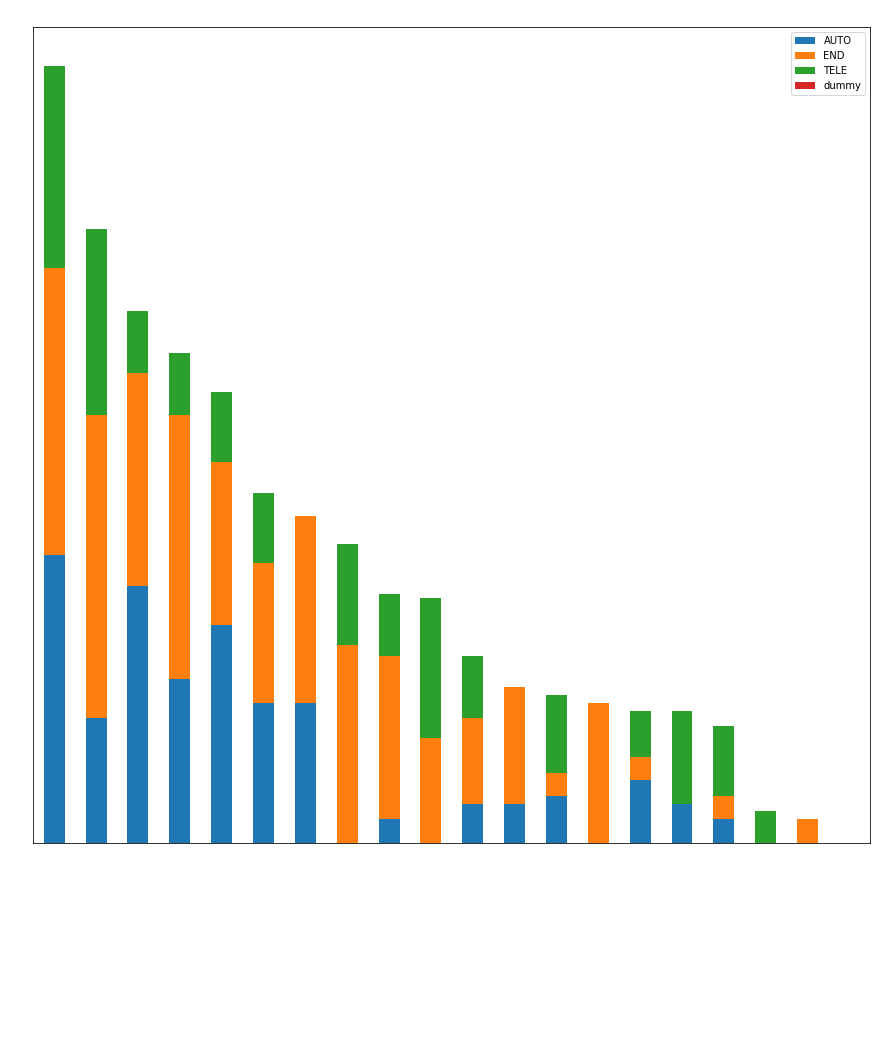

In [34]:
#sort it
matchdivdata = matchdivdata.sort_values(['TOTAL'], ascending=False)

#plot it
matchdivdata.loc[:, matchdivdata.columns.difference(exclude)].groupby(
    ['dummy']).plot(x='TEAM_NUM', kind='bar', stacked=True)

#style it
plt.title("Team vs. Total Pts; A/T/E", color='white', fontsize=17)
plt.xlabel("Team Name", color='white', fontsize=17)
plt.tick_params(colors='white')

# Change tick labels to team name
ax = plt.axes()
labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
for i in range(len(labels)):
    labels[i] = teamDict[int(labels[i])]
# print(labels)
ax.set_xticklabels(labels, fontsize=12)
plt.show()

### Average Point Table Generator

In [35]:
def getStatPoints(tNum, stat):
    #return avg stat procs * how many pts stat is worth
    return round(teamProbs.loc[teamList.index(tNum), stat] / 100 * refMatrix[stat][1], 2)

In [36]:
#monte carlo version:
'''
if refMatrix[stat][3] is "BOOL":
        if random.randint(1, 100) <= teamProbs.loc[teamList.index(tNum), stat]:
            return refMatrix[stat][1]
        else:
            return 0
    elif refMatrix[stat][3] is "INT":
        #return avg stat procs * how many pts stat is worth
        return round(teamProbs.loc[teamList.index(tNum), stat] * refMatrix[stat][1], 2)
'''

'\nif refMatrix[stat][3] is "BOOL":\n        if random.randint(1, 100) <= teamProbs.loc[teamList.index(tNum), stat]:\n            return refMatrix[stat][1]\n        else:\n            return 0\n    elif refMatrix[stat][3] is "INT":\n        #return avg stat procs * how many pts stat is worth\n        return round(teamProbs.loc[teamList.index(tNum), stat] * refMatrix[stat][1], 2)\n'

In [37]:
def getTeamPoints(tNum):
    pointCt = 0
    for stat in rfMtxOrder:
        pointCt += getStatPoints(tNum, stat)
    return round(pointCt, 2)

In [38]:
teamList = []
for i in teamProbs['TEAM_NUM']:
    if i not in teamList:
        teamList.append(i)
print(teamList)

NameError: name 'teamProbs' is not defined

In [ ]:
teamPtsAvg = pd.DataFrame(columns=['TEAM_NUM', 'AVG_PTS'])

In [ ]:
# for i in teamList:
#     print("{}\t{}".format(i, getTeamPoints(i)))
#     teamPtsAvg.loc[len(teamPtsAvg) + 1, 'TEAM_NUM'] = i
#     teamPtsAvg.loc[len(teamPtsAvg), 'AVG_PTS'] = getTeamPoints(i)

In [ ]:
teamPtsAvg = teamPtsAvg.sort_values(by=['AVG_PTS'], ascending = False)
teamPtsAvg.head(24)

In [ ]:
export_teamPtsAvg = teamPtsAvg.to_csv("teamPtsAvg.csv")

In [ ]:
def getStatPoints(tNum, stat):
    #return avg stat procs * how many pts stat is worth
    return round(teamProbs.loc[teamList.index(tNum), stat] / 100 * refMatrix[stat][1], 2)

#monte carlo version:
'''
if refMatrix[stat][3] is "BOOL":
        if random.randint(1, 100) <= teamProbs.loc[teamList.index(tNum), stat]:
            return refMatrix[stat][1]
        else:
            return 0
    
    elif refMatrix[stat][3] is "INT":
        #return avg stat procs * how many pts stat is worth
        return round(teamProbs.loc[teamList.index(tNum), stat] * refMatrix[stat][1], 2)
'''

def getTeamPoints(tNum):
    pointCt = 0
    for stat in rfMtxOrder:
        pointCt += getStatPoints(tNum, stat)
    return round(pointCt, 2)

teamProbs = pd.read_csv("teamProbs.csv")
teamProbs.drop(teamProbs.columns[0],axis=1,inplace=True)
teamProbs.head(24)

teamList = []
for i in teamProbs['TEAM_NUM']:
    if i not in teamList:
        teamList.append(i)
print(teamList)

teamPtsAvg = pd.DataFrame(columns=['TEAM_NUM', 'AVG_PTS'])

for i in teamList:
    print("{}\t{}".format(i, getTeamPoints(i)))
    teamPtsAvg.loc[len(teamPtsAvg) + 1, 'TEAM_NUM'] = i
    teamPtsAvg.loc[len(teamPtsAvg), 'AVG_PTS'] = getTeamPoints(i)

teamPtsAvg = teamPtsAvg.sort_values(by=['AVG_PTS'], ascending = False)
teamPtsAvg.head(24)

# export_teamPtsAvg = teamPtsAvg.to_csv("teamPtsAvg.csv")